# 학습 목표
1. 단백질-단백질 상호작용(PPI)의 기본 개념 이해
2. 사전 학습된 단백질 언어 모델(ProtBERT) 활용 방법 학습
3. 딥러닝 기반 PPI 예측 모델 구현
4. 모델 평가 및 결과 해석


<img src='https://analyticalsciencejournals.onlinelibrary.wiley.com/cms/asset/b6e907b7-245f-4b4d-96dc-6c5a529c45a2/pmic13702-fig-0004-m.jpg'>

## 0. 기본 설정

In [ ]:
!pip install torch transformers numpy pandas matplotlib seaborn scikit-learn networkx biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 58.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling n

In [ ]:
!wget https://downloads.thebiogrid.org/Download/BioGRID/Latest-Release/BIOGRID-ALL-LATEST.tab3.zip
!unzip BIOGRID-ALL-LATEST.tab3.zip

import pandas as pd
ppi_data = pd.read_csv('BIOGRID-ALL-4.4.243.tab3.txt', sep='\t')

--2025-03-27 04:45:10--  https://downloads.thebiogrid.org/Download/BioGRID/Latest-Release/BIOGRID-ALL-LATEST.tab3.zip
Resolving downloads.thebiogrid.org (downloads.thebiogrid.org)... 173.255.198.187
Connecting to downloads.thebiogrid.org (downloads.thebiogrid.org)|173.255.198.187|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/download]
Saving to: ‘BIOGRID-ALL-LATEST.tab3.zip’

BIOGRID-ALL-LATEST.     [              <=>   ] 163.36M  45.1MB/s    in 4.1s    

2025-03-27 04:45:14 (39.8 MB/s) - ‘BIOGRID-ALL-LATEST.tab3.zip’ saved [171292788]

Archive:  BIOGRID-ALL-LATEST.tab3.zip
  inflating: BIOGRID-ALL-4.4.243.tab3.txt  


<ipython-input-2-fd17cfce91ed>:5: DtypeWarning: Columns (1,2,18) have mixed types. Specify dtype option on import or set low_memory=False.
  ppi_data = pd.read_csv('BIOGRID-ALL-4.4.243.tab3.txt', sep='\t')


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import BertModel, BertTokenizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix, classification_report
import networkx as nx
import re
import random
import warnings
warnings.filterwarnings('ignore')

# 시각화 설정
plt.style.use('ggplot')
sns.set(style='whitegrid')

# GPU 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 1. 단백질-단백질 상호작용(PPI) 개요
- 정의: 두 개 이상의 단백질 분자가 물리적으로 결합하여 생화학적 기능을 수행하는 현상
- 실험적 방법: Yeast two-hybrid(Y2H), 면역침강법(Co-IP), 질량분석법(MS) 등
- 예측 기법
    - 전통적인 방법: 서열 유사성, 도메인 정보, 구조 정보 등을 활용한 예측
    - 최신 기법: 단백질 구조(contact map), 단백질 언어 모델 등을 활용한 예측

**주요 데이터 베이스**
- STRING: https://string-db.org/
    - 실험적으로 검증된 상호작용뿐만 아니라 계산적 예측 방법을 통해 도출된 상호작용도 포함
    - 각 상호작용에 신뢰도 점수를 부여하여 데이터의 품질을 평가할 수 있게 함
    - 기능적 단백질 연관성(functional protein associations)에 중점을 두고 있어 직접적인 물리적 상호작용뿐만 아니라 같은 대사 경로에 속하는 단백질들 간의 기능적 관계도 포함
- BioGRid: https://thebiogrid.org/
    - 물리적 상호작용(physical interactions)과 유전적 상호작용(genetic interactions) 모두를 포함
    - 모든 상호작용 데이터는 출판된 문헌에서 직접 추출한 실험적으로 검증된 데이터만을 포함
    - 각 상호작용에 대한 실험 방법, 출처 등 상세한 메타데이터를 제공


<img src='https://media.springernature.com/lw685/springer-static/image/art%3A10.1038%2Fs41598-019-41552-z/MediaObjects/41598_2019_41552_Fig2_HTML.png'>

<img src='https://www.cusabio.com/manage/upload/202404/Protein-protein-interaction-docking.jpg'>

# 2. 데이터 로드

In [ ]:
# BioGRID 데이터 로드
ppi_data = pd.read_csv('BIOGRID-ALL-4.4.243.tab3.txt', sep='\t')
print(f"원본 데이터 크기: {ppi_data.shape}")

# 필요한 컬럼만 선택
cols = [
    '#BioGRID Interaction ID',
    'Official Symbol Interactor A',
    'Official Symbol Interactor B',
    'Entrez Gene Interactor A',
    'Entrez Gene Interactor B',
    'Experimental System',
    'Experimental System Type',
    'Organism Name Interactor A',
    'Organism Name Interactor B'
]
ppi_data = ppi_data[cols]

# 컬럼명 변경
ppi_data.columns = [
    'interaction_id',
    'protein_a',
    'protein_b',
    'gene_id_a',
    'gene_id_b',
    'exp_system',
    'exp_type',
    'organism_a',
    'organism_b'
]

# 인간 단백질 상호작용만 필터링
human_ppi = ppi_data[
    (ppi_data['organism_a'] == 'Homo sapiens') &
    (ppi_data['organism_b'] == 'Homo sapiens')
]
print(f"인간 PPI 데이터 크기: {human_ppi.shape}")

# 물리적 상호작용만 필터링
physical_ppi = human_ppi[human_ppi['exp_type'] == 'physical']
print(f"물리적 상호작용 데이터 크기: {physical_ppi.shape}")

# 데이터 샘플 확인
print("\n전처리된 데이터 샘플:")
print(physical_ppi.head())

# 실험 방법 분포 확인
print("\n실험 방법 분포:")
print(physical_ppi['exp_system'].value_counts().head(10))

원본 데이터 크기: (2752018, 37)
인간 PPI 데이터 크기: (1181473, 9)
물리적 상호작용 데이터 크기: (1162775, 9)

전처리된 데이터 샘플:
   interaction_id protein_a protein_b gene_id_a gene_id_b  exp_system  \
0             103    MAP2K4      FLNC      6416      2318  Two-hybrid   
1             117      MYPN     ACTN2     84665        88  Two-hybrid   
2             183     ACVR1      FNTA        90      2339  Two-hybrid   
3             278     GATA2       PML      2624      5371  Two-hybrid   
4             418      RPA2     STAT3      6118      6774  Two-hybrid   

   exp_type    organism_a    organism_b  
0  physical  Homo sapiens  Homo sapiens  
1  physical  Homo sapiens  Homo sapiens  
2  physical  Homo sapiens  Homo sapiens  
3  physical  Homo sapiens  Homo sapiens  
4  physical  Homo sapiens  Homo sapiens  

실험 방법 분포:
exp_system
Affinity Capture-MS         624557
Proximity Label-MS          150149
Two-hybrid                  115710
Affinity Capture-Western     82765
Co-fractionation             70929
Reconstituted C

## 3. 데이터 전처리

### 3-1. 단백질 목록 추출 및 중복 제거

In [ ]:
# 단백질 A와 B를 합쳐서 중복 없는 단백질 목록 생성
proteins_a = set(physical_ppi['protein_a'])
proteins_b = set(physical_ppi['protein_b'])
all_proteins = proteins_a.union(proteins_b)
print(f"총 단백질 수: {len(all_proteins)}")

# 상호작용 수가 많은 상위 단백질 확인
protein_counts = pd.concat([
    physical_ppi['protein_a'].value_counts(),
    physical_ppi['protein_b'].value_counts()
], axis=1).fillna(0)
protein_counts.columns = ['count_as_a', 'count_as_b']
protein_counts['total_count'] = protein_counts['count_as_a'] + protein_counts['count_as_b']
protein_counts = protein_counts.sort_values('total_count', ascending=False)

print("\n상호작용 수 상위 10개 단백질:")
print(protein_counts.head(10))

# 분석에 사용할 단백질 수 제한 (상위 300개)
top_proteins = protein_counts.index[:300].tolist()
print(f"\n분석에 사용할 단백질 수: {len(top_proteins)}")

총 단백질 수: 20019

상호작용 수 상위 10개 단백질:
        count_as_a  count_as_b  total_count
PARK2       5656.0       313.0       5969.0
MYC         5137.0       471.0       5608.0
TP53        3312.0      2246.0       5558.0
TRIM67      4841.0         6.0       4847.0
CUL3        4262.0       568.0       4830.0
ZRANB1      4378.0        44.0       4422.0
RPA1        3299.0       468.0       3767.0
UBC         2153.0      1539.0       3692.0
RPA2        3200.0       300.0       3500.0
ESR1        2936.0       483.0       3419.0

분석에 사용할 단백질 수: 300


### 3-2. UniProt에서 단백질 서열 획득

In [ ]:
import requests
import time

def get_uniprot_sequence(protein_symbol):
    """
    UniProt에서 단백질 심볼로 단백질 서열을 검색합니다.

    Args:
        protein_symbol (str): 검색할 단백질 심볼 (예: 'TP53')

    Returns:
        str: 단백질 서열 또는 검색 실패 시 None
    """
    try:
        # 직접 검색 URL 구성 (간단한 방식)
        search_url = f"https://rest.uniprot.org/uniprotkb/search?query={protein_symbol}+AND+organism_id:9606&format=tsv&fields=accession"

        response = requests.get(search_url)
        if response.status_code != 200 or not response.text.strip():
            return None

        # TSV 응답에서 첫 번째 UniProt ID 추출
        lines = response.text.strip().split('\n')
        if len(lines) < 2:  # 헤더만 있고 결과가 없음
            return None

        uniprot_id = lines[1].strip()

        # 서열 가져오기
        time.sleep(0.5)  # API 요청 사이에 짧은 지연 추가
        fasta_url = f"https://rest.uniprot.org/uniprotkb/{uniprot_id}.fasta"
        fasta_response = requests.get(fasta_url)

        if fasta_response.status_code != 200:
            return None

        # FASTA 형식에서 서열 추출
        fasta_text = fasta_response.text
        lines = fasta_text.strip().split('\n')

        if len(lines) <= 1:
            return None

        sequence = ''.join(lines[1:])
        return sequence

    except Exception:
        return None

# 단백질 서열 다운로드
protein_sequences = {}
for protein in top_proteins:
    protein_sequences[protein] = get_uniprot_sequence(protein)

print(f"총 다운로드한 단백질 서열 수: {len(protein_sequences)}")

# 샘플 단백질 서열 확인
print("\n샘플 단백질 서열:")
for protein, seq in list(protein_sequences.items())[:3]:
    print(f"{protein}: {seq[:50]}...")

총 다운로드한 단백질 서열 수: 300

샘플 단백질 서열:
PARK2: MIVFVRFNSSHGFPVEVDSDTSIFQLKEVVAKRQGVPADQLRVIFAGKEL...
MYC: MDFFRVVENQQPPATMPLNVSFTNRNYDLDYDSVQPYFYCDEEENFYQQQ...
TP53: MDPTGSQLDSDFSQQDTPCLIIEDSQPESQVLEDDSGSHFSMLSRHLPNL...


### 3-3. 단백질 임베딩 생성
- https://huggingface.co/Rostlab/prot_bert

In [ ]:
# ProtBERT 모델 및 토크나이저 로드
tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False)
model = BertModel.from_pretrained("Rostlab/prot_bert")
model = model.to(device)

tokenizer_config.json:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/81.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/361 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

In [ ]:
def get_protein_embedding(sequence, model, tokenizer, device, max_length=512):
    """단백질 서열에서 ProtBERT 임베딩 추출"""
    # 희귀 아미노산 'UZOB'를 'X'로 변환
    sequence = re.sub(r"[UZOB]", "X", sequence)

    # 서열이 너무 길 경우 자르기
    if len(sequence) > max_length - 2:  # [CLS] 및 [SEP] 토큰 고려
        sequence = sequence[:max_length - 2]

    # 서열 토큰화
    inputs = tokenizer(sequence, return_tensors='pt', padding='max_length',
                      max_length=max_length, truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # 임베딩 추출
    with torch.no_grad():
        outputs = model(**inputs)

    # [CLS] 토큰 임베딩 추출 (전체 서열 표현)
    cls_embedding = outputs.last_hidden_state[:, 0, :].cpu().numpy()

    # 평균 임베딩 추출 (모든 아미노산 표현의 평균)
    # [CLS]와 [SEP] 토큰 제외
    mask = inputs['attention_mask'].cpu().numpy()
    token_embeddings = outputs.last_hidden_state.cpu().numpy()

    # 마스크된 토큰 제외하고 평균 계산
    sum_embeddings = np.sum(token_embeddings * mask[:, :, np.newaxis], axis=1)
    sum_mask = np.sum(mask, axis=1)
    mean_embedding = sum_embeddings / sum_mask[:, np.newaxis]

    return cls_embedding[0], mean_embedding[0]

In [ ]:
# 모든 단백질에 대한 임베딩 추출
print("단백질 임베딩 추출 중...")
protein_embeddings = {}

for i, (protein, sequence) in enumerate(protein_sequences.items()):
    if i % 20 == 0:
        print(f"처리 중: {i}/{len(protein_sequences)}")

    cls_embedding, mean_embedding = get_protein_embedding(sequence, model, tokenizer, device)
    protein_embeddings[protein] = {
        'cls': cls_embedding,
        'mean': mean_embedding
    }

print(f"임베딩 추출 완료: {len(protein_embeddings)} 단백질")

# 임베딩 차원 확인
embedding_dim = protein_embeddings[list(protein_embeddings.keys())[0]]['cls'].shape[0]
print(f"임베딩 차원: {embedding_dim}")

단백질 임베딩 추출 중...
처리 중: 0/300
처리 중: 20/300
처리 중: 40/300
처리 중: 60/300
처리 중: 80/300
처리 중: 100/300
처리 중: 120/300
처리 중: 140/300
처리 중: 160/300
처리 중: 180/300
처리 중: 200/300
처리 중: 220/300
처리 중: 240/300
처리 중: 260/300
처리 중: 280/300
임베딩 추출 완료: 300 단백질
임베딩 차원: 1024


## 4. 데이터세트 구축

In [ ]:
# 분석에 사용할 단백질만 필터링
filtered_ppi = physical_ppi[
    (physical_ppi['protein_a'].isin(protein_embeddings.keys())) &
    (physical_ppi['protein_b'].isin(protein_embeddings.keys()))
]

# 양성 샘플 생성 (실제 상호작용하는 단백질 쌍)
positive_pairs = []
for _, row in filtered_ppi.iterrows():
    # 단백질 이름을 알파벳 순으로 정렬하여 중복 방지
    pair = tuple(sorted([row['protein_a'], row['protein_b']]))
    positive_pairs.append(pair)

# 중복 제거
positive_pairs = list(set(positive_pairs))
print(f"양성 샘플 수: {len(positive_pairs)}")

# 음성 샘플 생성 (무작위 단백질 쌍)
random.seed(42)
proteins_list = list(protein_embeddings.keys())
negative_pairs = []
negative_set = set()  # 중복 검사를 위한 집합

while len(negative_pairs) < len(positive_pairs):
    p1 = random.choice(proteins_list)
    p2 = random.choice(proteins_list)

    # 자기 자신과의 상호작용은 제외하고, 알파벳 순으로 정렬하여 중복 방지
    if p1 != p2:
        pair = tuple(sorted([p1, p2]))
        # 양성 샘플에 없고, 아직 추가하지 않은 경우만 추가
        if pair not in positive_pairs and pair not in negative_set:
            negative_pairs.append(pair)
            negative_set.add(pair)

print(f"음성 샘플 수: {len(negative_pairs)}")

양성 샘플 수: 18766
음성 샘플 수: 18766


In [ ]:
def create_pair_features(pair, embedding_type='mean'):
    """단백질 쌍에 대한 특징 벡터 생성"""
    p1, p2 = pair

    # 임베딩 특징
    emb_p1 = protein_embeddings[p1][embedding_type]
    emb_p2 = protein_embeddings[p2][embedding_type]

    # 1. 특징 결합 방법: 연결
    concat_features = np.concatenate([emb_p1, emb_p2])

    # 2. 특징 결합 방법: 차이
    diff_features = np.abs(emb_p1 - emb_p2)

    # 3. 특징 결합 방법: 요소별 곱
    prod_features = emb_p1 * emb_p2

    # 모든 특징 결합
    all_features = np.concatenate([concat_features, diff_features, prod_features])

    return all_features

In [ ]:
# 데이터셋 구축
print("특징 벡터 생성 중...")
X = []
y = []

# 양성 샘플 처리
for i, pair in enumerate(positive_pairs):
    if i % 100 == 0:
        print(f"양성 샘플 처리 중: {i}/{len(positive_pairs)}")
    X.append(create_pair_features(pair))
    y.append(1)  # 양성 샘플 레이블

# 음성 샘플 처리
for i, pair in enumerate(negative_pairs):
    if i % 100 == 0:
        print(f"음성 샘플 처리 중: {i}/{len(negative_pairs)}")
    X.append(create_pair_features(pair))
    y.append(0)  # 음성 샘플 레이블

# 넘파이 배열로 변환
X = np.array(X)
y = np.array(y)

print(f"특징 벡터 크기: {X.shape}")
print(f"레이블 분포: 양성={sum(y)}, 음성={len(y)-sum(y)}")

# 데이터 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 학습/검증/테스트 데이터 분할
X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"학습 데이터: {X_train.shape}, 검증 데이터: {X_val.shape}, 테스트 데이터: {X_test.shape}")

특징 벡터 생성 중...
양성 샘플 처리 중: 0/18766
양성 샘플 처리 중: 100/18766
양성 샘플 처리 중: 200/18766
양성 샘플 처리 중: 300/18766
양성 샘플 처리 중: 400/18766
양성 샘플 처리 중: 500/18766
양성 샘플 처리 중: 600/18766
양성 샘플 처리 중: 700/18766
양성 샘플 처리 중: 800/18766
양성 샘플 처리 중: 900/18766
양성 샘플 처리 중: 1000/18766
양성 샘플 처리 중: 1100/18766
양성 샘플 처리 중: 1200/18766
양성 샘플 처리 중: 1300/18766
양성 샘플 처리 중: 1400/18766
양성 샘플 처리 중: 1500/18766
양성 샘플 처리 중: 1600/18766
양성 샘플 처리 중: 1700/18766
양성 샘플 처리 중: 1800/18766
양성 샘플 처리 중: 1900/18766
양성 샘플 처리 중: 2000/18766
양성 샘플 처리 중: 2100/18766
양성 샘플 처리 중: 2200/18766
양성 샘플 처리 중: 2300/18766
양성 샘플 처리 중: 2400/18766
양성 샘플 처리 중: 2500/18766
양성 샘플 처리 중: 2600/18766
양성 샘플 처리 중: 2700/18766
양성 샘플 처리 중: 2800/18766
양성 샘플 처리 중: 2900/18766
양성 샘플 처리 중: 3000/18766
양성 샘플 처리 중: 3100/18766
양성 샘플 처리 중: 3200/18766
양성 샘플 처리 중: 3300/18766
양성 샘플 처리 중: 3400/18766
양성 샘플 처리 중: 3500/18766
양성 샘플 처리 중: 3600/18766
양성 샘플 처리 중: 3700/18766
양성 샘플 처리 중: 3800/18766
양성 샘플 처리 중: 3900/18766
양성 샘플 처리 중: 4000/18766
양성 샘플 처리 중: 4100/18766
양성 샘플 처리 중: 4200/18766
양성 샘플 처리 

## 5. 모델 구축

In [ ]:
class PPIDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.FloatTensor(features)
        self.labels = torch.FloatTensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# 데이터셋 및 데이터로더 생성
train_dataset = PPIDataset(X_train, y_train)
val_dataset = PPIDataset(X_val, y_val)
test_dataset = PPIDataset(X_test, y_test)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
class PPIPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dims=[1024, 512, 256, 128], dropout_rate=0.4):
        super(PPIPredictor, self).__init__()

        # 배치 정규화 적용
        self.bn_input = nn.BatchNorm1d(input_dim)

        # 입력층 -> 첫 번째 은닉층
        layers = [
            nn.Linear(input_dim, hidden_dims[0]),
            nn.BatchNorm1d(hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        ]

        # 은닉층 구성
        for i in range(len(hidden_dims)-1):
            layers.extend([
                nn.Linear(hidden_dims[i], hidden_dims[i+1]),
                nn.BatchNorm1d(hidden_dims[i+1]),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ])

        # 출력층
        layers.append(nn.Linear(hidden_dims[-1], 1))
        layers.append(nn.Sigmoid())

        # Sequential 모델로 구성
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = self.bn_input(x)
        return self.model(x).squeeze()

In [ ]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # 그래디언트 초기화
        optimizer.zero_grad()

        # 순전파
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # 역전파 및 최적화
        loss.backward()
        optimizer.step()

        # 통계
        running_loss += loss.item() * inputs.size(0)
        predicted = (outputs >= 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    return epoch_loss, epoch_acc

def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_outputs = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # 순전파
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # 통계
            running_loss += loss.item() * inputs.size(0)
            predicted = (outputs >= 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # 예측값과 실제값 저장
            all_outputs.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    return epoch_loss, epoch_acc, all_outputs, all_labels

In [ ]:
# 모델 초기화
input_dim = X_train.shape[1]
model = PPIPredictor(input_dim).to(device)
print(model)

# 손실 함수 및 옵티마이저 정의
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# 학습률 스케줄러 정의
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, verbose=True
)

# 학습 파라미터
num_epochs = 50
best_val_loss = float('inf')
best_model_state = None
early_stop_patience = 10
no_improve_epochs = 0

# 학습 기록
train_losses = []
train_accs = []
val_losses = []
val_accs = []

# 학습 시작
for epoch in range(num_epochs):
    # 학습
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

    # 검증
    val_loss, val_acc, val_outputs, val_labels = validate(model, val_loader, criterion, device)

    # 학습률 스케줄러 업데이트
    scheduler.step(val_loss)

    # 기록 저장
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # 최적 모델 저장
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict().copy()
        no_improve_epochs = 0
    else:
        no_improve_epochs += 1

    # 학습 진행 상황 출력
    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # 조기 종료(Early stopping)
    if no_improve_epochs >= early_stop_patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

# 최적 모델 복원
model.load_state_dict(best_model_state)
print(f"Best validation loss: {best_val_loss:.4f}")

PPIPredictor(
  (bn_input): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (model): Sequential(
    (0): Linear(in_features=4096, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=512, out_features=256, bias=True)
    (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.4, inplace=False)
    (12): Linear(in_features=256, out_features=128, bias=True)
    (13): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.4, inplace=False)
    (16): Linear(in_features=

## 6. 시각화 및 성능 평가

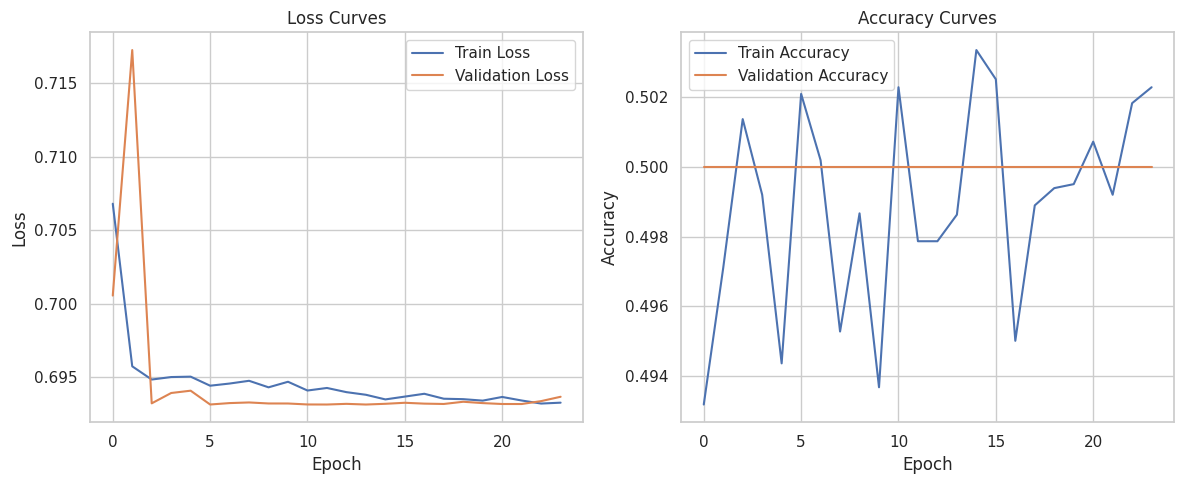

In [ ]:
# 학습 곡선 시각화
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# 테스트 데이터 성능 평가
test_loss, test_acc, test_outputs, test_labels = validate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

# ROC 곡선 및 AUC 계산
fpr, tpr, _ = roc_curve(test_labels, test_outputs)
roc_auc = auc(fpr, tpr)

# PR 곡선 및 AUC 계산
precision, recall, _ = precision_recall_curve(test_labels, test_outputs)
pr_auc = average_precision_score(test_labels, test_outputs)

# 이진 예측값 생성
test_preds = (np.array(test_outputs) >= 0.5).astype(int)

# 혼동 행렬
cm = confusion_matrix(test_labels, test_preds)

# Classification report
report = classification_report(test_labels, test_preds)

print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR AUC: {pr_auc:.4f}")
print("\n혼동 행렬:")
print(cm)
print("\n분류 보고서:")
print(report)

Test Loss: 0.6937, Test Accuracy: 0.5000
ROC AUC: 0.5000
PR AUC: 0.5000

혼동 행렬:
[[2815    0]
 [2815    0]]

분류 보고서:
              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67      2815
         1.0       0.00      0.00      0.00      2815

    accuracy                           0.50      5630
   macro avg       0.25      0.50      0.33      5630
weighted avg       0.25      0.50      0.33      5630



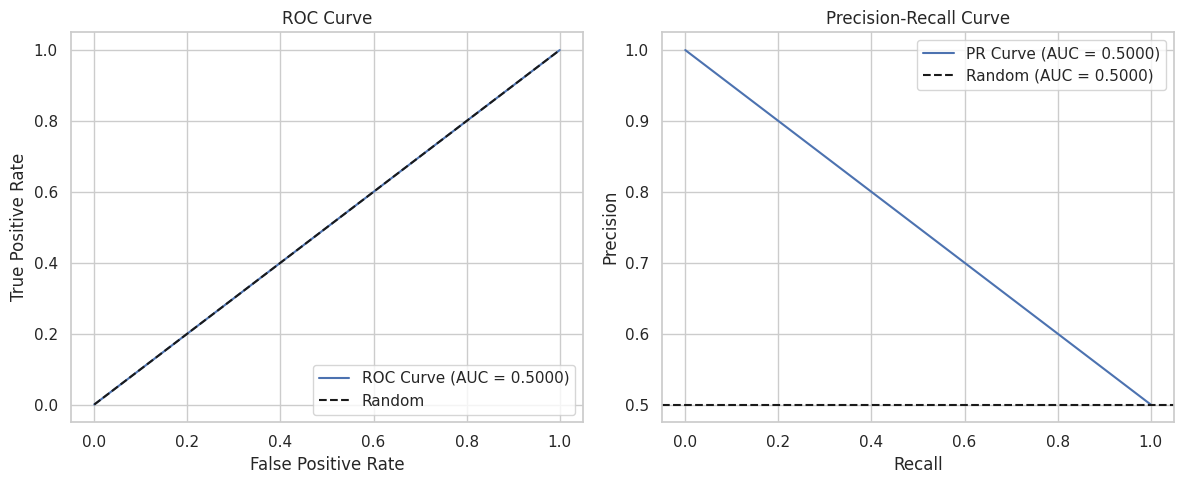

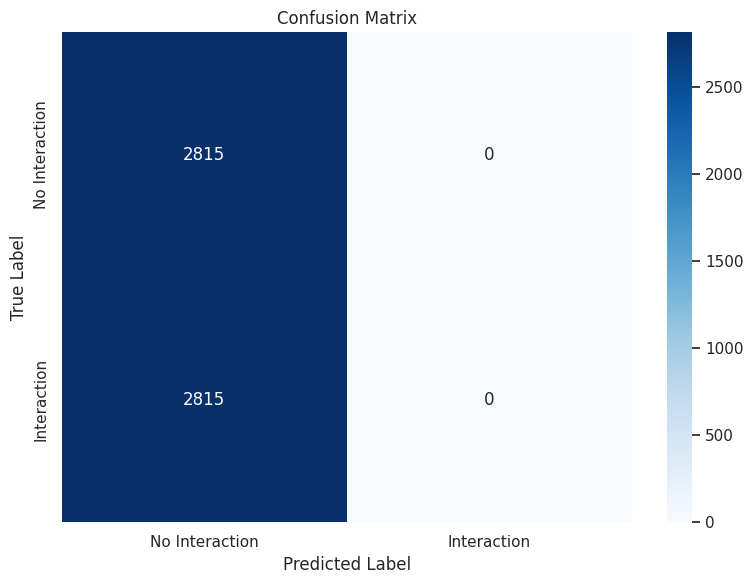

In [ ]:
# ROC 및 PR 곡선 시각화
plt.figure(figsize=(12, 5))

# ROC 곡선
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)

# PR 곡선
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.4f})')
plt.axhline(y=sum(test_labels)/len(test_labels), color='k', linestyle='--',
            label=f'Random (AUC = {sum(test_labels)/len(test_labels):.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

# 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Interaction', 'Interaction'],
            yticklabels=['No Interaction', 'Interaction'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()